In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
from glob import glob
import wget
import requests
import netCDF4 as nc4

In [23]:
folder = "E:\Veranico_HD\\raw_datasets\chirps\\"
for year in range(1980, 2021):
    url = 'https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/chirps-v2.0.' + str(year) + '.days_p05.nc'
    FILENAME = os.path.join(folder, str(year) +'.nc')
    result = requests.get(url)
    try:
        result.raise_for_status()
        f = open(FILENAME,'wb')
        f.write(result.content)
        f.close()
        print('contents of URL written to '+FILENAME)
    except:
        print('requests.get() returned an error code '+str(result.status_code))

requests.get() returned an error code 404
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1981.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1982.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1983.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1984.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1985.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1986.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1987.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1988.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1989.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1990.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1991.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1992.nc
contents of URL written to E:\Veranico_HD\raw_datasets\chirps\1993.nc
contents of URL written to E:\Veranico_HD\raw_da

# clean

In [3]:
lat_min = -25
lat_max = -2
lon_min = -61
lon_max = -42
date_start= '1981-01-01'
date_end = '2020-12-31'
dataset = 'chirps'


In [32]:
# Specify the path to the folder containing the NetCDF files
folder_path = r"E:\Veranico_HD\raw_datasets\\" + dataset
# Open and concatenate all the NetCDF files
ds = xr.open_mfdataset(os.path.join(folder_path, '*.nc'), combine='by_coords')


In [33]:
ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
ds = ds.rename({'precip': 'pr'})
ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=slice(date_start, date_end))
ds.to_netcdf(r'E:\Veranico_HD\clean_cerrado\\' + dataset + '.nc')

In [3]:
# CDD
from funcs import *
ds = xr.open_dataset(r'E:\Veranico_HD\clean_cerrado\\' + dataset + '.nc')
cdd = cdd_numba(ds.pr)
cdd.to_netcdf(r"D:\GU\IC\Veranico\daily_datasets\CDD\\" + dataset + '.nc')

d:\GU\IC\Veranico\funcs.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  daa = xr.apply_ufunc(


# EDA

In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd

In [4]:
cdd = xr.open_dataset(r"D:\GU\IC\Veranico\daily_datasets\CDD\\" + dataset + '.nc')

In [5]:
cdd

<xarray.Dataset>
Dimensions:  (lat: 460, lon: 380, time: 14610)
Coordinates:
  * lat      (lat) float32 -24.98 -24.92 -24.88 -24.83 ... -2.125 -2.075 -2.025
  * lon      (lon) float32 -60.98 -60.93 -60.88 -60.83 ... -42.12 -42.07 -42.03
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2020-12-31
Data variables:
    CDD      (lat, lon, time) float64 ...

In [9]:
regions = gpd.read_file(r"D:\GU\IC\Scripts\Data\regions1.geojson")
mm = cdd.where(cdd > 5).mean(dim='time')


c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\xarray\core\indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\xarray\core\indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\luisg

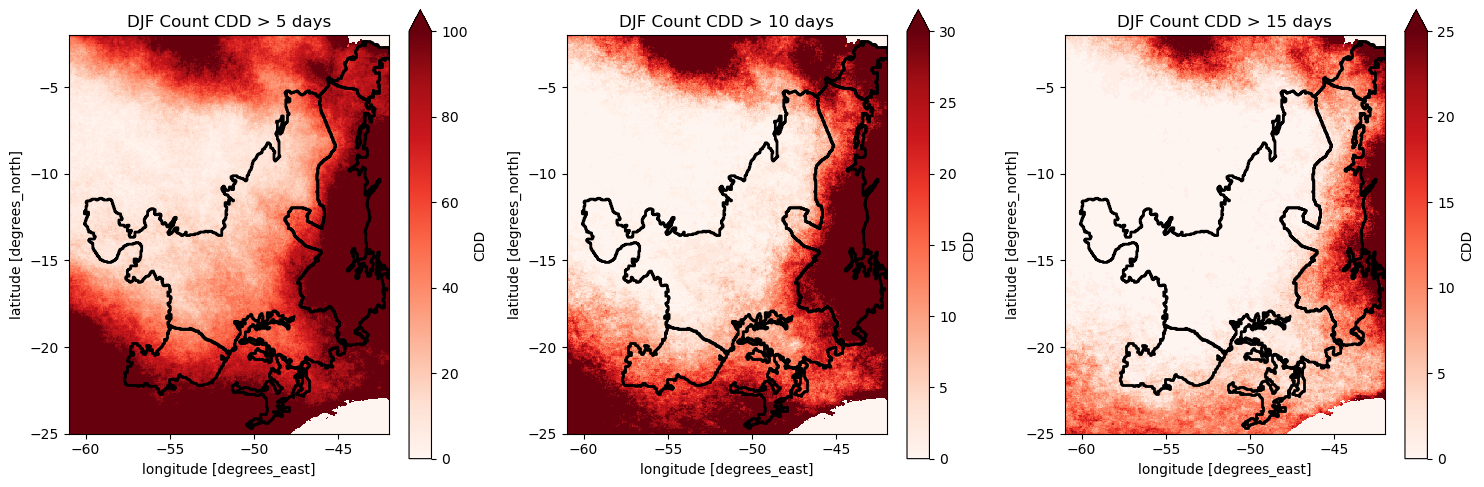

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
cdd.sel(time=cdd['time.season'] == 'DJF').where(cdd > 5).count(dim='time').plot(ax=axs[0],  cmap='Reds', vmax=100)
cdd.sel(time=cdd['time.season'] == 'DJF').where(cdd > 10).count(dim='time').plot(ax=axs[1], cmap='Reds', vmax=30)
cdd.sel(time=cdd['time.season'] == 'DJF').where(cdd > 15).count(dim='time').plot(ax=axs[2], cmap='Reds', vmax=25)
for i in range(3):
    axs[i].set_title('DJF Count CDD > ' + str([5, 10, 15][i]) + ' days')
    regions.plot(ax=axs[i], color='none', edgecolor='black', linewidth=2)

plt.tight_layout()

<AxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

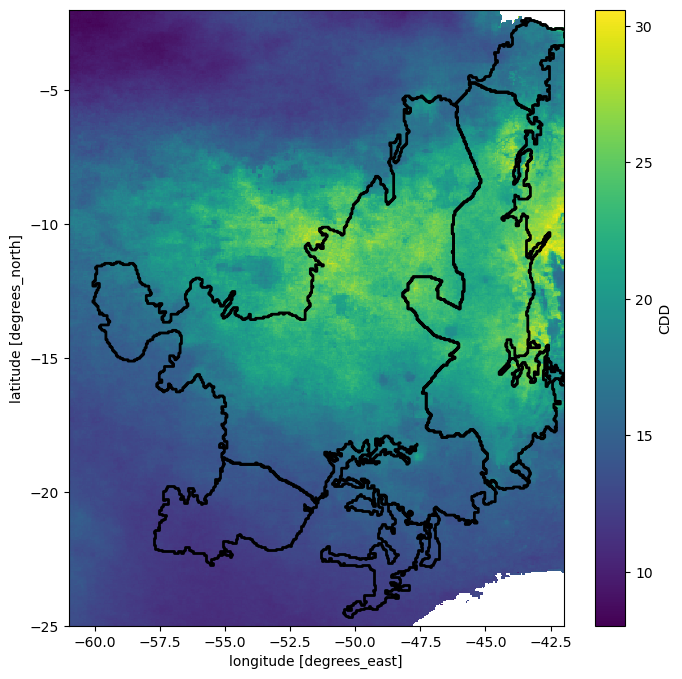

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
mm.plot(ax=ax)
regions.plot(ax=ax, color='none', edgecolor='black', linewidth=2)